# EEG Processing Exploration
# Interactive exploration of EEG processing pipeline stages

In [1]:
# Initial imports
from src.eeg_processor.pipeline import EEGPipeline

In [3]:
# Initialize processor
pipeline = EEGPipeline()

## Load Raw Data

In [4]:
# Direct file loading (alternative if participant handler isn't working)
raw_data_path = 'C:/Users/sayee/Documents/Research/PythonCode/EEG_Processor/tests/test_data/curry/'
participant_file = 'S_011_M.dat'

raw = pipeline.load_raw(raw_data_path + participant_file)
print(raw.info)
raw.plot_sensors(show_names=True)


FileNotFoundError: fname does not exist: "C:\Users\sayee\Documents\Research\PythonCode\EEG_Processor\tests\test_data\curry\S_011_M.dat"

<span style="color:red;"> # The VEOG and HEOG shouldn't be in the headplot montage, we need to fix this </span>

In [5]:
# Identify EOG and trigger channels (adjust names if needed)
eog_channels = ["HEOG", "VEOG"]  # Replace with your actual EOG channel names
trigger_channel = "Trigger"         # Replace with your trigger channel name

# Set correct channel types
raw.set_channel_types({
    **{ch: "eog" for ch in eog_channels},  # Mark EOGs
    trigger_channel: "stim"                 # Mark trigger (optional, see Step 3)
})
raw.plot_sensors(show_names=True)

NameError: name 'raw' is not defined

### Plot psd graph for all electrodes

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\sayee\Documents\Research\PythonCode\EEG_Processor\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


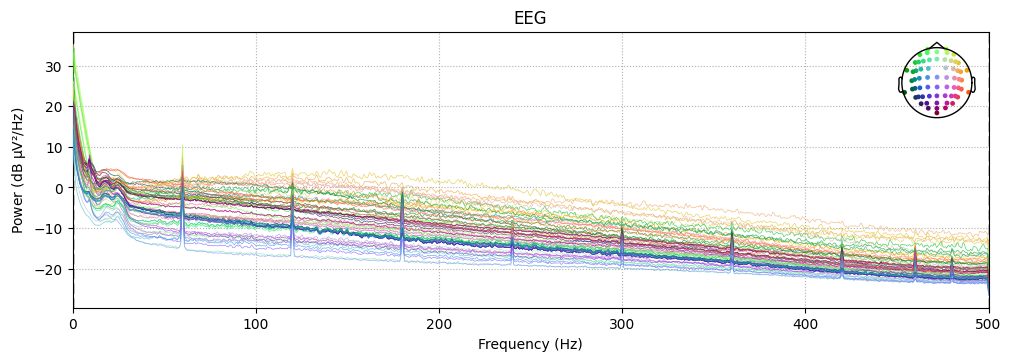

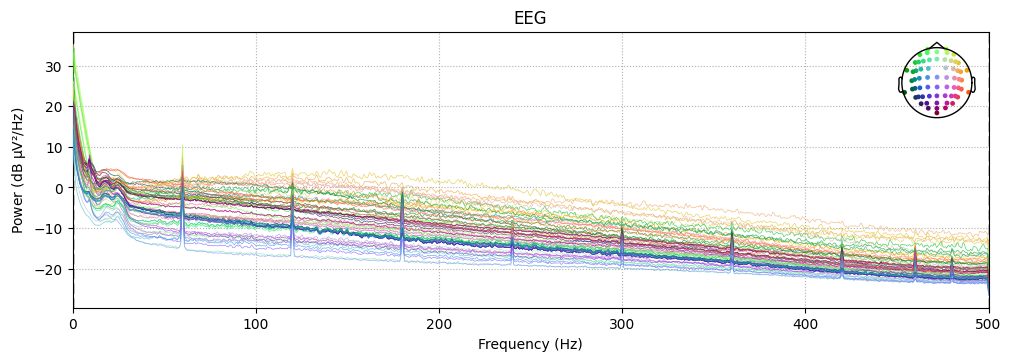

In [6]:
nyquist = raw.info["sfreq"] / 2
raw.compute_psd(fmax=nyquist).plot()

### Plot the raw data (decimated for plotting speed)

In [7]:
raw_decimated = raw.copy().resample(sfreq=300)
raw_decimated.plot()


Using qt as 2D backend.


## Processing Pipeline


### Cropping Stage

In [ ]:
crop_params = {
    'crop_after': 30,
    'crop_before': 39,
}

cond3 = pipeline.apply_stage(raw, "crop", **crop_params) # applying a stage modifies the raw object directly

### Filtering Stage


In [ ]:
# Apply filter
filter_params = {
    'l_freq': 1,
    'h_freq': 50,
}

filtered = pipeline.apply_stage(cond3, "filter", **filter_params)
filtered.compute_psd(fmax=80).plot()


### Bad Channel Detection


In [ ]:
# Detect bad channels
bad_ch_params = {
    'segment_wise': False,
    'verbose': True,
    'interpolate': True,
    'show_plot': True,
    'plot_duration': 5
}

clean = pipeline.apply_stage(filtered, "detect_bad_channels", **bad_ch_params)

### Rereference

In [ ]:
# Apply average reference
reref_params = {
    'method': 'average',
    'exclude': ['EOG']  # List channels to exclude
}

rereferenced = pipeline.apply_stage(clean, "rereference", **reref_params)
print(rereferenced.info)


### ICA blink removal


In [ ]:
# Apply ica blink correction
ica_params = {
    'method': 'ica',
    'plot_components': True,
    'enable_manual': True
}

corrected = pipeline.apply_stage(rereferenced, "blink_artifact", **ica_params)
print(corrected.info)

### Plot Data Before Epoching

In [ ]:
corrected.plot()

### Epoching


In [ ]:
# Define condition and epoch
condition = {
    "name": "Inhibition",
    "epoch_events": {"Onset": 31, "Offset": 32},
    "condition_markers": [30, 39],
}

epoch_params = {
    'tmin': -1,
    'tmax': 3,
    'baseline': [-0.1, 0],
    'reject': {'eeg': 250e-6},
}


# Set condition and epoch
pipeline.processor.set_condition(condition)
epochs = pipeline.apply_stage(corrected, "epoch", **epoch_params)
epochs.plot_drop_log()

### Plot some diagnostic figures

In [ ]:
stim = epochs['Onset']
silence = epochs['Offset']

stim.plot_image(picks='Fz')
stim.plot_psd(fmax=30)
stim.compute_psd().plot_topomap()
silence.plot_image(picks='Fz')
silence.plot_psd(fmax=30)
silence.compute_psd().plot_topomap()

## Average across Epochs

In [ ]:
stim_evoked = stim.average()
sil_evoked = silence.average()

import mne
mne.viz.plot_compare_evokeds([stim_evoked, sil_evoked], picks='Fz')